# Documentation of the NB_IoT environment

This notebook explains how to use the NB_IoT environment.

## Global Parameters

There are 3 global parameters that must be set with ```set_global_parameters``` defined in ```parameters.py```:

* ```N```: the number of UEs included in the state observation
* ```H```: (horizon) the number of future subframes observed in the states
* ```Nc```: the number of carriers handled by the system

The following lines must be include bebore any other ```import``` statement

In [ ]:
# determine global parameters before any other system import
from system.parameters import set_global_parameters
set_global_parameters(N = 4, H = 40, Nc = 1)

There are two ways to create an instance of the NBIoT system:
1) with the auxiliary function ```create_system``` in ```test_utils.py```
2) element-by-element

Let's start with the first way

## System Creation with ```create_system```

The arguments of this function are:
* ```rng```: an random generator created with ```default_rng``` from ```numpy.random```
* ```conf```: a dictionary with the system configuration

In [ ]:
# import system creation function
from system.system_creator import create_system

# random number generator object
from numpy.random import default_rng

Define the configuration

In [ ]:
# simulator configuration
conf = {
    'animate_carrier': True, # to generate an animation of the carrier occupation
    'ratio': 1, # ratio of uniform/beta traffic
    'M': 1500, # number of UEs
    'levels': [0,1,2], # simulated CE levels
    'buffer_range': [100, 500], # range for the number of bits in the UE buffer
    'reward_criteria': 'average_delay', # there are multiple criteria defined in perf_monitor.py
    'statistics': True, # to store historical data for statistical evaluation
    'animate_stats': False, # to generate an animation of the statsitics over time
    'sc_adjustment': True, # to automatically adjust the number of subcarriers
    'mcs_automatic': True # to autimatically select mcs and Nrep
    }

In [ ]:
# create random number generator
rng = default_rng(seed = 827)

# create system
node, perf_monitor, population, carrier = create_system(rng, conf)

# check global variables
print(f'carriers = {node.n_carriers}')

We can run a step-by-step simulation of the system as follows

In [ ]:
# this auxiliary function generates a simple default action
from system.test_utils import generate_reasonable_action

In [ ]:
# reset the system
o, info = node.reset()

# generate initial action
action = generate_reasonable_action(rng, o)

print(action)

# simulation loop
n = 0
while node.time < 500:
    n += 1
    o, r, Done, info = node.step(action) 
    action = generate_reasonable_action(rng, o)
    print(action)
    if n % 10 == 0:
        print(f'event: {n}, time {node.time}, reward: {r}')

## Video Generation

In [ ]:
# we can generate an animation of the carrier resource occupation process
movie_name = "1_nbiot_carrier_movie"
carrier.generate_movie(movie_name = movie_name)

In [ ]:
# imports for video insertion in the notebook
import io
import base64
from IPython.display import HTML

In [ ]:
# code for inserting the video
video = io.open(f'./movies/{movie_name}.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="500" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

## Element-by-Element System Creation

The system can also be created element-by-element using the following classes:
* ```MessageSwitch```: a pseudo-broker class to allow message passing among the objects of the system
* ```Carrier```: simulates the carriers
* ```Channel```: simulates the channel
* ```UE_generator```: traffic generation
* ```AccessProcedure```: simulates the access procedure in the NPRACH
* ```RxProcedure```: simulates data reception for the NPUSCH
* ```PerfMonitor```: generates rewards and stores performance metrics
* ```NodeB```: simulates the Node B

In [7]:
from system.node_b import NodeB
from system.population import Population
from system.carrier import Carrier
from system.channel import Channel
from system.access_procedure import AccessProcedure
from system.rx_procedure import RxProcedure
from system.ue_generator import UEGenerator
from system.perf_monitor import PerfMonitor
from system.message_switch import MessageSwitch

In [8]:
# random number generator object
from numpy.random import default_rng

# create random number generator
rng = default_rng(seed = 5)

# the order of creation is important
m = MessageSwitch()
carrier = Carrier(m, animation = False)
channel = Channel(rng, m)
ue_generator = UEGenerator(rng, m, M = 2000, ratio = 1)
population = Population(rng, m, levels = [0,1,2])
access = AccessProcedure(rng,m)
receptor = RxProcedure(m)
perf_monitor = PerfMonitor(m, reward_criteria = 'average_delay', statistics = True, animation = False)
node = NodeB(m, sc_adjustment = True, mcs_automatic = False)

## Agent Creation

Agents inherit from the ```DummyAgent``` class which provides the basic atributes:
* ```action_items```: list with the action items controlled by the agent
* ```s_mask```: list with the state indexes observed by the agent
* ```next```: integer pointing to the id of the next agent to take over in the same state
* ```states```: list with the Node B states where the agent operates

In [9]:
# parameters.py contains predefined s_mask lists
from system.parameters import scheduling_indexes, ce_selection_indexes, nprach_indexes

# agents.py defines DummyAgent and a list of actions for NPRACH control
from data_agents import DummyAgent, nprach_actions

In [10]:
# agent configurations:

agent_0 = {
    'id': 0, # index of the agent
    'action_items': ['id', 'Imcs', 'Nrep'], # action items controlled by this agent
    's_mask': scheduling_indexes, # state indexes observed by this agent
    'next': 1, # next agent operating in the same nodeb state
    'states': ['Scheduling'] # nodeb state where this agent operates 
    }

agent_1 = {
    'id': 1, # carrier, delay and subcarriers
    'action_items': ['carrier', 'delay', 'sc'],
    's_mask': scheduling_indexes,
    'next': -1,
    'states': ['Scheduling']
    }

agent_2 = {
    'id': 2, # ce_level selection
    'action_items': ['carrier', 'ce_level', 'rar_Imcs', 'delay', 'sc', 'Nrep'],
    's_mask': ce_selection_indexes,
    'next': -1,
    'states': ['RAR_window']
}

agent_3 = {
    'id': 3, # backoff selection
    'action_items': ['backoff'],
    's_mask': nprach_indexes,
    'next': -1,
    'states': ['RAR_window_end'],
}

agent_4 = {
    'id': 4, # NPRACH configuration
    'action_items': nprach_actions,
    's_mask': nprach_indexes,
    'next': -1,
    'states': ['NPRACH_update']
}

In [11]:
# agents are arranged in a list ordered by their id attribute
agents = [
    DummyAgent(agent_0),
    DummyAgent(agent_1),
    DummyAgent(agent_2),
    DummyAgent(agent_3),
    DummyAgent(agent_4)
]

## Controller Creation

The Controller class creates an object that orchestrates the list of agents to operate the system.

Two attributes are required:
* the controlled system
* the list of agents

In [12]:
from controller import Controller

In [13]:
# create the controller
controller = Controller(node, agents = agents)

# reset the environment
_ = controller.reset()

# run time specified in ms
controller.run_until(5000)

>> CONTROLLER AGENT REGISTER
{'Scheduling': [0, 1], 'RAR_window': [2], 'RAR_window_end': [3], 'NPRACH_update': [4]}


## Learning with Stable-Baselines Agents

One of the agents in the list can be replaced by an external agent provided by stable baselines 

In [14]:
from stable_baselines import A2C
from stable_baselines.common.cmd_util import make_vec_env
from wrappers import BasicSchedulerWrapper
import gym

/Users/juanjosealcaraz/anaconda3/envs/RL_lite/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/juanjosealcaraz/anaconda3/envs/RL_lite/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/juanjosealcaraz/anaconda3/envs/RL_lite/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/juanjo

In [15]:
# reset the environment
_ = controller.reset()

# set external agent specifying the index
controller.set_ext_agent(0)
print(' > External agent configured')
print(' ')

# create the gym environment
nbiot_env = gym.make('gym_system:System-v1', system = controller)
print(' > gym environment created')
print(' ')

# wrap the environment
nbiot_env = BasicSchedulerWrapper(nbiot_env)
print(' > environment wrapped')
print(' ')

# prepare the agent
env = make_vec_env(lambda: nbiot_env, n_envs=1)
print(' > vectorised environment created')
print(' ')

# create the agent 
model = A2C('MlpPolicy', env, verbose=0, seed = 7)
print(' > Model created!')
print(' ')

# and learn
model.learn(total_timesteps = 10_000)
print(' > Learning completed!')
print(' ')

 > External agent configured
 
 > gym environment created
 
 > environment wrapped
 
 > vectorised environment created
 
 > Model created!
 
 > Learning completed!
 


## Sequential Learning with Multiple Agents

In the following example the learning process is divided into two phases:
* First an online learning agent learns how to select the transmission parameters for a selected user
* Second an external rl agent from stable baselines learns how to select a user 

In [17]:
# import the online agent, a random user selection agent, and a predefined agent configuration
from data_agents import OnlineClassifierAgent, RandomUserAgent, agents_conf

# import a simple wrapper for the external rl agent selecting the UE
from wrappers import BasicWrapper

In [18]:
# online classifier agent
mcs_agent = OnlineClassifierAgent(agents_conf[1], rng)

# create agents
agents = [
    RandomUserAgent(agents_conf[0], rng),
    mcs_agent,
    DummyAgent(agents_conf[2]),
    DummyAgent(agents_conf[3]),
    DummyAgent(agents_conf[4]),
    DummyAgent(agents_conf[5])
]

In [19]:
# a new agent must be created 
controller = Controller(node, agents = agents)
_ = controller.reset()

# run phase 1
controller.run_until(30_000)
print(' > Phase 1 completed')
print(' ')

>> CONTROLLER AGENT REGISTER
{'Scheduling': [0, 1, 2], 'RAR_window': [3], 'RAR_window_end': [4], 'NPRACH_update': [5]}
 > Phase 1 completed
 


In [20]:
# deactivate mcs learning
mcs_agent.deactivate_learning()
print(' > Online learning deactivated')
print(' ')

# reconfigure controller
controller.set_ext_agent(0)
print(' > Controller reconfigured')
print(' ')

# move to the next step
controller.to_next_step()
print(' > Controller advanced to next step')
print(' ')

# create the gym environment
controller.soft_reset = True # to avoid reseting the node b
nbiot_env = gym.make('gym_system:System-v1', system = controller)
print(' > gym environment created')
print(' ')

# wrap the environment
nbiot_env = BasicWrapper(nbiot_env)
print(' > environment wrapped')
print(' ')

# prepare the agent
env = make_vec_env(lambda: nbiot_env, n_envs=1)
print(' > vectorised environment created')
print(' ')

# create the model and learn
agent = A2C('MlpPolicy', env, verbose=0, seed = 7)
print(' > RL agent created')
print(' ')


 > Online learning deactivated
 
 > Controller reconfigured
 
 > Controller advanced to next step
 
 > gym environment created
 
 > environment wrapped
 
 > vectorised environment created
 
 > RL agent created
 


In [21]:
# learn with the RL agent
agent.learn(total_timesteps = 30_000)
print(' > Phase 2 completed!')
print(' ')

 > Phase 2 completed!
 


In [22]:
from system.test_utils import moving_average
import matplotlib.pyplot as plt
%matplotlib inline

 POPULATION RA
 UEs in CE 0: 1
 UEs in CE 1: 3
 UEs in CE 2: 3

 POPULATION Contention list
 UE in contention: 2

  Connected UEs: 4

  Scheduled UEs: 2

  Served UEs: 18949

PERFORMANCE METRICS: 

 >> arrivals: 18964, departures: 18949

 >> backoffs: 2239

 >> access time: 180.26, tx time: 118.46, total delay: 298.72

 >> errors: 4908, attempts: 23857



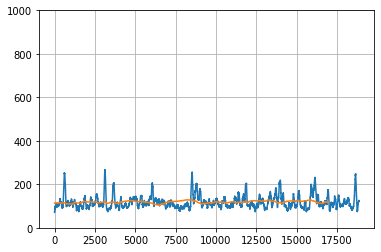

In [23]:
population.brief_report()
node.brief_report()
history = moving_average(perf_monitor.delay_history, 100)
av_hist = moving_average(perf_monitor.delay_history, 2000)
plt.figure()
plt.plot(history)
plt.plot(av_hist)
plt.ylim([0, 1000])
plt.grid()
plt.show()